In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn

In [ ]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
! python curate_db.py 

In [57]:
all_dat = pd.read_csv('./curated.csv', index_col=0)
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]

In [61]:
# sift out pwrs
# train_dat = train_dat.loc[train_dat['reactor_type'] == 'PWR']

(97959, 63)

In [62]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[3:]
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}
print(category)

{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'cm-248', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'am-241', 'am-243', 'cm-243', 'cm-242'], 'nottru': ['ra-226', 'pa-231', 'am-242m', 'cf-251', 'cf-249', 'ac-227', 'u-234', 'u-236', 'u-238', 'th-229', 'th-232', 'th-230', 'u-232']}





u235
u-235


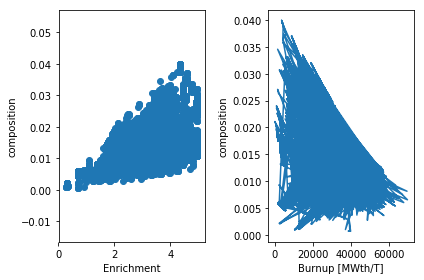

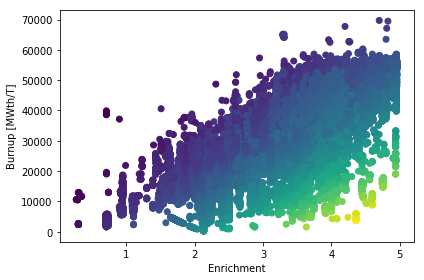




bred_fissile
pu-239


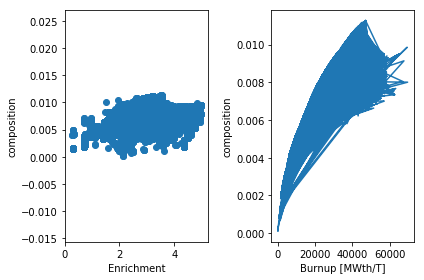

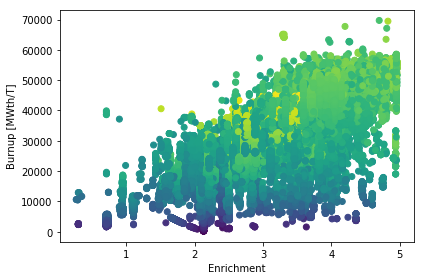

u-233


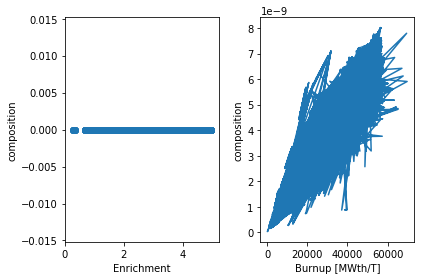

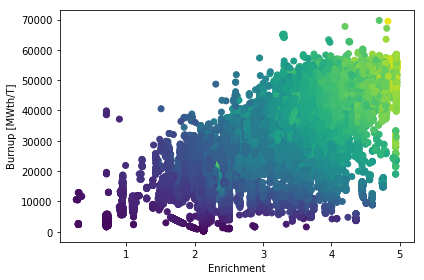




fp
zr-93


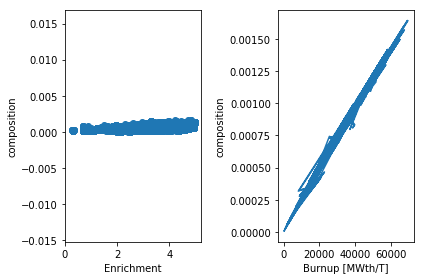

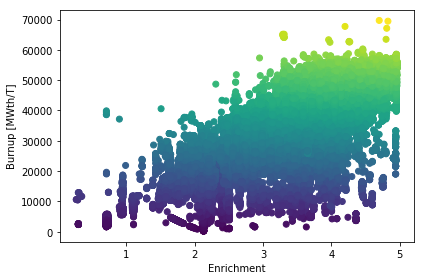

ru-103


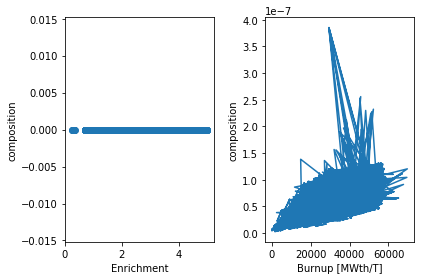

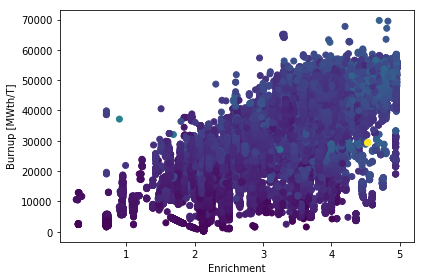

ru-106


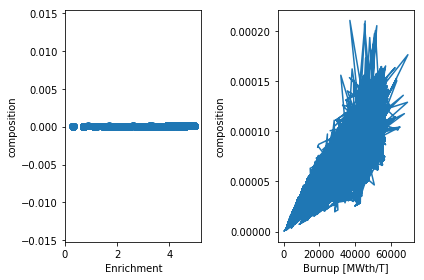

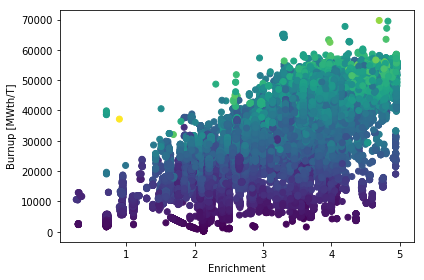

sb-124


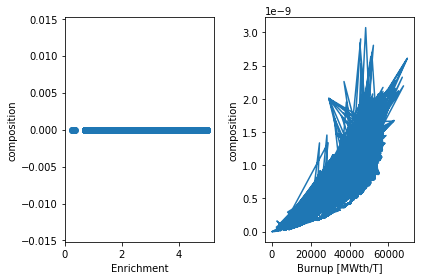

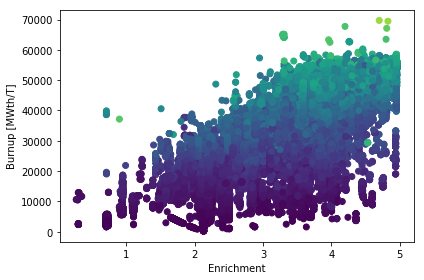

sb-125


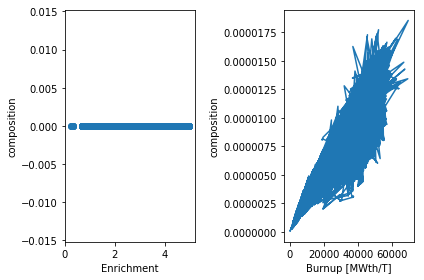

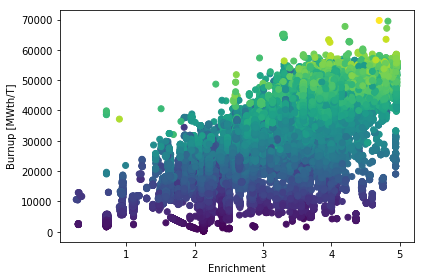

nb-95


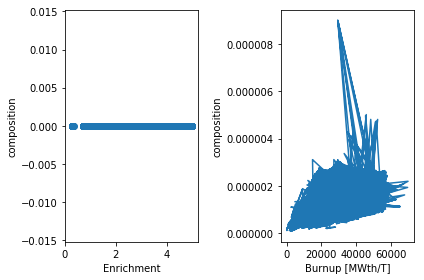

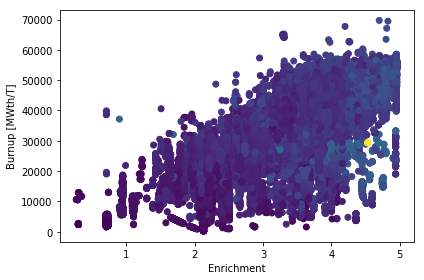

pd-107


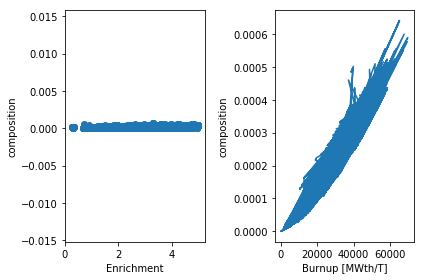

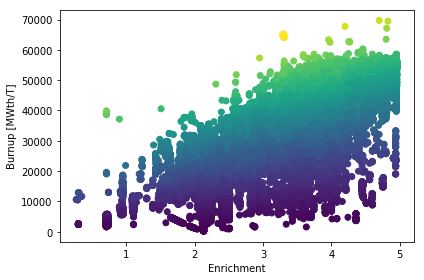

pm-147


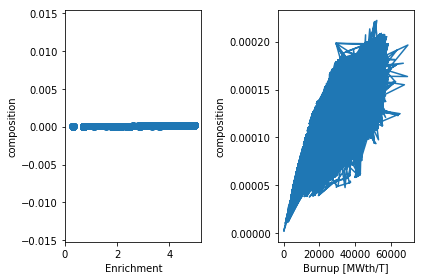

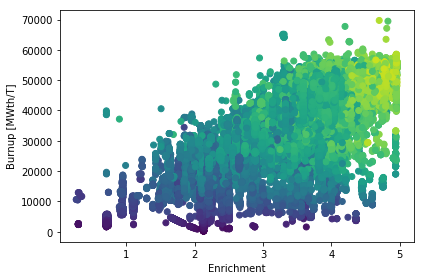

i-129


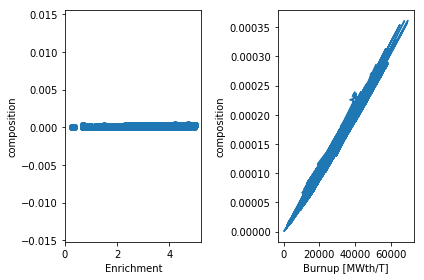

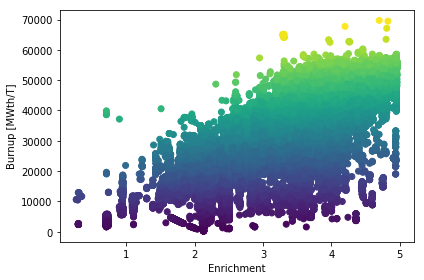

h-3


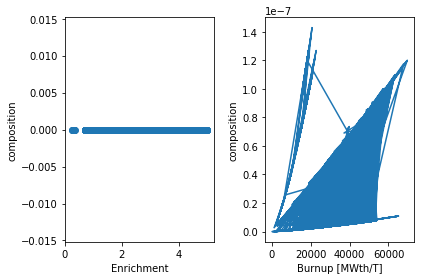

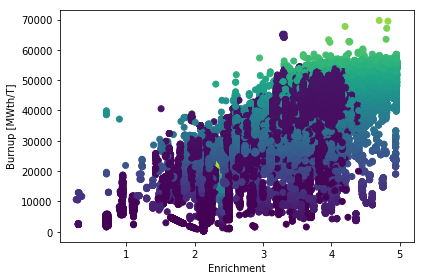

kr-85


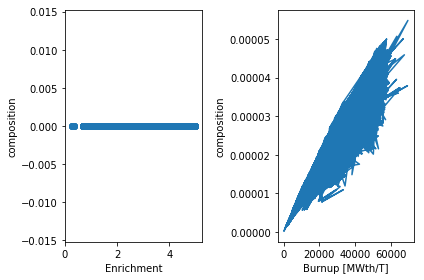

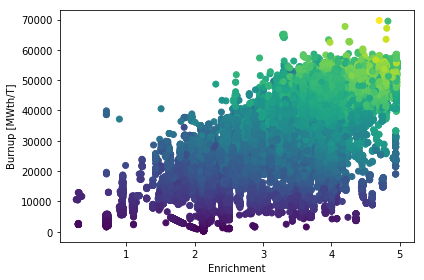

nb-94


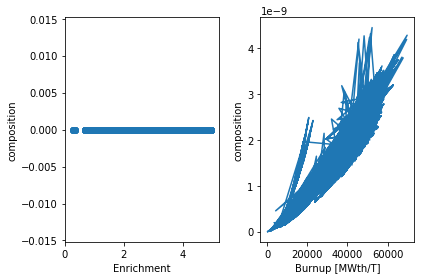

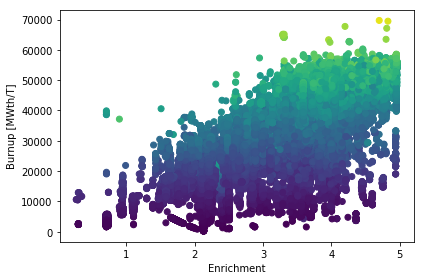

cs-134


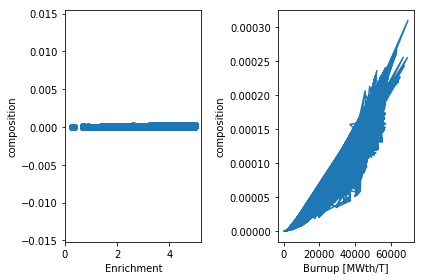

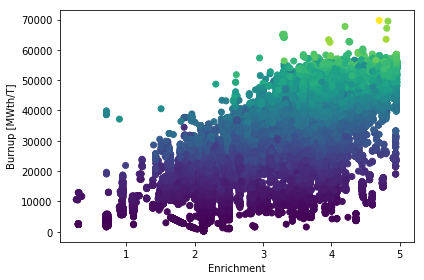

cs-135


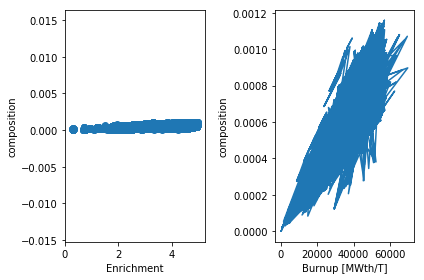

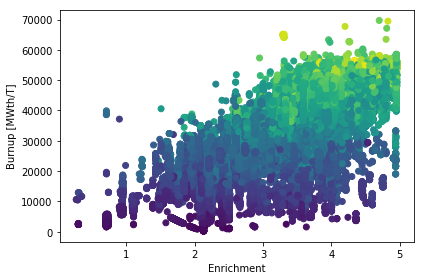

eu-152


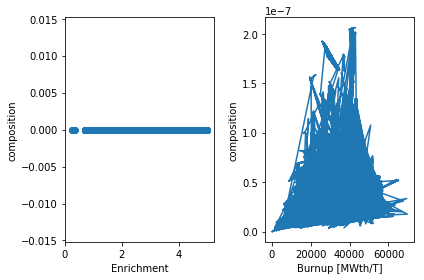

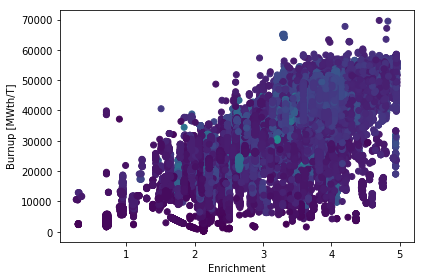

cs-137


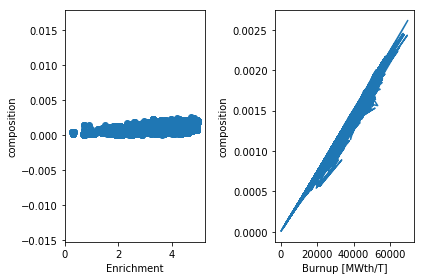

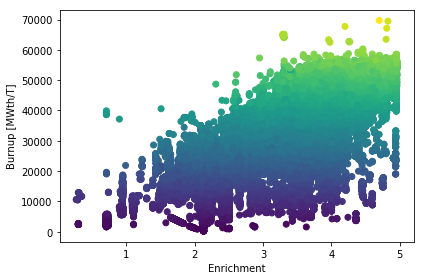

eu-154


In [ ]:
def plot_side_by_side(x1, y1, x2, y2, xlabel1, xlabel2):
    
    plt.subplot(1, 2, 1)
    plt.scatter(x1, y1)
    plt.xlabel(xlabel1)
    plt.ylabel('composition')

    plt.subplot(1, 2, 2)
    plt.scatter(x2, y2)
    plt.xlabel(xlabel2)
    plt.ylabel('composition')
    
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.scatter(x1,x2, c=y1)
    plt.xlabel(xlabel1)
    plt.ylabel(xlabel2)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    
# show two plots (subfigs) with x = [burnup, enrichment] and y = isotope composition
x1 = list(train_dat['init_enr'])
x2 = list(train_dat['bu'])        
for key, val in category.items():
    print('\n\n')
    print(key)
    for iso in val:
        y = list(train_dat[iso])
        print(iso)
        plot_side_by_side(x1, y, x2, y, 'Enrichment', 'Burnup [MWth/T]')

In [63]:
# using deep neural nets
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

model = Sequential()
# input layer
model.add(Dense(128, kernel_initializer='normal', input_dim=2, activation='relu'))

# hidden layer
model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# output layer
model.add(Dense(len(iso_list), kernel_initializer='normal', activation='linear'))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam',
              metrics=['mean_absolute_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 60)                15420     
Total params: 48,828
Trainable params: 48,828
Non-trainable params: 0
_________________________________________________________________


In [64]:
# train it
input_ = train_dat.as_matrix(columns=train_dat.columns[1:3])
output_ = train_dat.as_matrix(columns=train_dat.columns[3:])
print(input_)
print(output_)
print(output_.shape)

model.fit(input_, output_, validation_split=0.2)

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[[3.80229998e+00 4.19191010e+04]
 [3.80060000e+00 3.80004000e+04]
 [3.80080009e+00 4.32718980e+04]
 ...
 [3.81000000e+00 4.38730000e+04]
 [3.81000000e+00 4.10890000e+04]
 [3.81000000e+00 4.42450000e+04]]
[[1.76051346e-06 1.00595398e-03 3.31489226e-14 ... 1.80795623e-09
  1.50152085e-09 4.84959269e-09]
 [1.61152547e-06 9.20251499e-04 3.51753898e-14 ... 1.93162541e-09
  1.24523223e-09 4.75351206e-09]
 [1.20867557e-06 1.03510468e-03 6.52195542e-14 ... 2.46971114e-09
  1.97867599e-09 5.00327026e-09]
 ...
 [1.54346072e-06 1.05763941e-03 4.29467495e-14 ... 2.02402697e-09
  1.76260867e-09 4.75360597e-09]
 [1.02262676e-06 9.96634256e-04 8.16861898e-14 ... 2.83809028e-09
  1.89023290e-09 4.82823366e-09]
 [1.55515675e-06 1.06575080e-03 4.27044367e-14 ... 2.01110365e-09
  1.79038598e-09 4.75725387e-09]]
(146937, 60)
Train on 117549 samples, validate on 29388 samples
Epoch 1/1
117549/117549 [==============================] - 9s 76us/step - loss: 1.1876 - mean_absolute_error: 1.1876 - val_loss: 2.6

In [70]:
# test it
test_input = test_dat.as_matrix(columns=test_dat.columns[1:3])
answer = test_dat.as_matrix(columns=test_dat.columns[3:])

z = model.predict(input_)
x = list(train_dat)[4:]
for indx, val in enumerate(x):
    print(val, z[0][indx], '\t', answer[0][indx])

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


zr-93 -5.9424536e-05 	 1.3227583166859769e-06
ra-226 0.00071394164 	 0.0009043617869543721
ru-103 -6.925287e-05 	 4.769553865427733e-14
ru-106 -0.00029556826 	 7.167049899608124e-08
sb-124 6.8815105e-05 	 8.802522566933441e-05
sb-125 6.8690897e-06 	 8.73468877612418e-10
pu-238 -0.0001038431 	 1.0155649662524144e-05
pu-239 0.00023707248 	 0.00022760372067437694
np-237 0.007879673 	 0.0070937090027705565
nb-95 0.00037463487 	 0.0005724604274300464
pa-231 0.00012994895 	 1.5604441089629463e-06
pd-107 0.00015879022 	 5.455813020852221e-10
pm-147 0.00021995764 	 0.0002546270456549877
pu-240 5.0168892e-05 	 0.0001575834740811381
pu-241 0.0022888742 	 0.00249883246806588
pu-244 0.001670431 	 0.0016429741583550712
pu-242 7.8301266e-05 	 3.752844184518108e-08
i-129 0.00045759795 	 0.0005512064974351208
h-3 0.00021863775 	 0.00017834198603489652
kr-85 -0.0002008692 	 5.940241908704909e-08
nb-94 9.589657e-05 	 2.671631959311585e-05
cm-248 0.00028389605 	 1.7152605296326894e-09
cs-134 0.0004306331

=================================

In [4]:
train_dat.describe()

,reactor_id,init_enr,bu,zr-95,zr-93,ra-226,ru-103,ru-106,sb-124,sb-125,...,th-229,tc-99,sm-151,se-79,sr-90,sn-126,th-232,th-230,u-232,u-233
count,244896.000000,244896.000000,244896.000000,2.448960e+05,244896.000000,2.448960e+05,2.448960e+05,2.448960e+05,2.448960e+05,2.448960e+05,...,2.448960e+05,244896.000000,2.448960e+05,2.448960e+05,244896.000000,2.448960e+05,2.448960e+05,2.448960e+05,2.448960e+05,2.448960e+05
mean,180.975471,3.392045,36169.381303,1.065570e-06,0.000879,7.689542e-14,6.142781e-08,8.049953e-05,9.386174e-10,9.640985e-06,...,2.806368e-12,0.000850,1.686570e-05,5.078688e-06,0.000535,2.497518e-05,5.302327e-09,2.526345e-09,1.759868e-09,4.353182e-09
std,33.307693,0.793488,10888.030891,4.084599e-07,0.000259,5.644625e-14,2.309096e-08,2.851938e-05,4.003711e-10,2.845690e-06,...,2.244471e-12,0.000247,3.505460e-06,1.505677e-06,0.000170,7.534535e-06,2.787098e-09,7.896308e-10,8.636979e-10,1.301461e-09
min,122.000000,0.270000,177.000000,6.700398e-08,0.000005,2.440462e-15,2.896937e-09,2.937289e-07,8.577491e-13,6.053311e-08,...,1.462548e-16,0.000005,2.430258e-07,2.735801e-08,0.000004,6.517541e-08,4.022150e-11,2.367902e-10,1.709104e-14,3.306749e-11
25%,154.000000,2.850000,29185.000000,7.802997e-07,0.000713,4.292764e-14,4.541561e-08,5.988568e-05,6.417179e-10,7.720185e-06,...,1.207973e-12,0.000692,1.509176e-05,4.113683e-06,0.000415,2.039239e-05,4.044908e-09,2.051413e-09,1.156027e-09,3.572561e-09
50%,184.000000,3.464709,37821.000000,9.857401e-07,0.000917,6.420174e-14,5.812993e-08,8.088114e-05,9.494164e-10,9.981915e-06,...,2.281493e-12,0.000888,1.753718e-05,5.304967e-06,0.000555,2.611041e-05,5.342410e-09,2.464068e-09,1.771581e-09,4.563775e-09
75%,207.000000,4.020000,44706.000000,1.297604e-06,0.001083,9.923866e-14,7.498323e-08,9.948272e-05,1.242266e-09,1.175545e-05,...,3.829837e-12,0.001041,1.942642e-05,6.232475e-06,0.000666,3.070256e-05,6.640755e-09,2.963081e-09,2.327382e-09,5.360320e-09
max,239.000000,4.965609,69693.000000,7.667760e-06,0.001642,1.137772e-12,3.852368e-07,2.107834e-04,3.073480e-09,1.853663e-05,...,2.695077e-11,0.001563,2.665856e-05,9.577442e-06,0.001026,5.207210e-05,8.757634e-08,1.008956e-08,6.581086e-09,8.017046e-09


In [5]:
# feature space:
# initial enrichment / burnup
x = train_dat.iloc[:, 2:4]
x

,init_enr,bu
163647,3.8023,41919.101
163648,3.8006,38000.400
163649,3.8008,43271.898
163650,3.8174,37646.199
163651,3.8019,40967.101
163652,3.8159,43961.101
163653,3.8139,35771.601
163654,3.8076,41890.898
163655,3.8023,41762.500
163656,3.8030,43283.300


In [6]:
# target space:
# unf composition
y = train_dat.iloc[:, 4:]
y

,zr-95,zr-93,ra-226,ru-103,ru-106,sb-124,sb-125,pu-238,pu-239,np-237,...,th-229,tc-99,sm-151,se-79,sr-90,sn-126,th-232,th-230,u-232,u-233
163647,1.760513e-06,0.001006,3.314892e-14,1.004372e-07,0.000121,1.303525e-09,0.000013,0.000300,0.008011,0.000683,...,1.117331e-12,0.000997,0.000019,0.000006,0.000652,0.000028,5.524887e-09,1.807956e-09,1.501521e-09,4.849593e-09
163648,1.611525e-06,0.000920,3.517539e-14,8.899557e-08,0.000105,1.037468e-09,0.000011,0.000245,0.007815,0.000612,...,9.093376e-13,0.000915,0.000018,0.000005,0.000603,0.000025,5.258762e-09,1.931625e-09,1.245232e-09,4.753512e-09
163649,1.208676e-06,0.001035,6.521955e-14,7.087211e-08,0.000097,1.026088e-09,0.000011,0.000345,0.008109,0.000705,...,2.545278e-12,0.001023,0.000018,0.000006,0.000655,0.000030,5.746980e-09,2.469711e-09,1.978676e-09,5.003270e-09
163650,1.598927e-06,0.000913,3.556035e-14,8.788937e-08,0.000103,1.012724e-09,0.000011,0.000241,0.007804,0.000606,...,8.921342e-13,0.000908,0.000018,0.000005,0.000599,0.000025,5.249725e-09,1.954226e-09,1.223588e-09,4.767989e-09
163651,1.724457e-06,0.000985,3.363133e-14,9.763231e-08,0.000117,1.235631e-09,0.000012,0.000286,0.007966,0.000666,...,1.064808e-12,0.000978,0.000018,0.000006,0.000640,0.000028,5.463629e-09,1.837321e-09,1.437772e-09,4.830316e-09
163652,1.226603e-06,0.001050,6.487694e-14,7.221101e-08,0.000099,1.062514e-09,0.000012,0.000355,0.008147,0.000718,...,2.635989e-12,0.001038,0.000019,0.000006,0.000664,0.000030,5.806465e-09,2.453323e-09,2.038082e-09,5.039864e-09
163653,1.526795e-06,0.000871,3.654570e-14,8.254723e-08,0.000095,8.999210e-10,0.000011,0.000216,0.007695,0.000571,...,8.015018e-13,0.000868,0.000017,0.000005,0.000575,0.000023,5.103824e-09,2.014863e-09,1.107846e-09,4.698766e-09
163654,1.759777e-06,0.001006,3.322178e-14,1.003248e-07,0.000121,1.300543e-09,0.000013,0.000299,0.008012,0.000683,...,1.115967e-12,0.000997,0.000019,0.000006,0.000652,0.000028,5.529008e-09,1.812101e-09,1.499959e-09,4.857434e-09
163655,1.754592e-06,0.001003,3.322858e-14,9.997432e-08,0.000120,1.292200e-09,0.000013,0.000297,0.008004,0.000680,...,1.108608e-12,0.000994,0.000019,0.000006,0.000650,0.000028,5.515027e-09,1.812799e-09,1.490977e-09,4.846697e-09
163656,1.209057e-06,0.001035,6.525623e-14,7.088701e-08,0.000097,1.026420e-09,0.000011,0.000345,0.008110,0.000706,...,2.546887e-12,0.001024,0.000018,0.000006,0.000655,0.000030,5.750270e-09,2.471089e-09,1.979852e-09,5.007019e-09


In [7]:
# looking at some correlations
print('correlations for bu with u-238 is ', x['bu'].corr(y['u-238']))
print('correlations for bu with pu-239 is ', x['bu'].corr(y['pu-239']))
print('correlations for init_enr with u-238 is ', x['init_enr'].corr(y['u-238']))
print('correlations for init_enr with pu-239 is ', x['init_enr'].corr(y['pu-239']))
print('correlations for init_enr with u-235 is ', x['init_enr'].corr(y['u-235']))


correlations for bu with u-238 is  -0.8452458177357214
correlations for bu with pu-239 is  0.48485563865886017
correlations for init_enr with u-238 is  -0.9136099986185887
correlations for init_enr with pu-239 is  0.31540721776839364


In [8]:
from sklearn import model_selection

In [9]:
validation_size = 0.2
x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=validation_size, random_state=420 )

In [22]:
def fit_and_test(model, x_train, x_val, y_train, y_val, train_dat):
    model.fit(x_train, y_train)
    predicted_df = pd.DataFrame(model.predict(x_val), columns=train_dat.columns.values[4:], index=x_val.index)
    indices = predicted_df.index
    error_dict = {}
    for indx in indices:
        est = predicted_df.loc[indx]
        actual = y_val.loc[indx]
        percent_err = (est-actual) / actual
        error_dict[indx] = percent_err
    error_df = pd.DataFrame.from_dict(error_dict, orient='index', columns=train_dat.columns.values[4:])
    
    err = []
    isotopes = []
    for isotope in error_df.columns.values:
        isotopes.append(isotope)
        err.append(np.mean(error_df[isotope].values) * 100)
    for indx, val in enumerate(isotopes):
        print(val, err[indx])
        

In [23]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
fit_and_test(lm, x_train, x_val, y_train, y_val, train_dat)


zr-95 7.57545680499191
zr-93 0.20058886118123237
ra-226 42.724952710420666
ru-103 7.026027924256356
ru-106 3.7440083738937457
sb-124 -10.511439479182656
sb-125 2.1199819112060956
pu-238 -520.4954602445418
pu-239 3.0689423070465525
np-237 -1.3037130311272658
nb-95 7.578101414303666
pa-231 15.517088433574353
pd-107 -2.71930345764323
pm-147 2.58673671263628
pu-240 4.644337090268303
pu-241 12.956046525687839
pu-244 -490394.8327160163
pu-242 -1257.9420531202065
i-129 0.015018822765561107
h-3 140.91887411545687
kr-85 0.2828468175362021
nb-94 -13.295460256052353
cm-248 -1.8166975181796628e+16
cs-134 -79.18752201654753
cs-135 5.2212733968611955
cm-245 -3041789593.5856256
cm-244 -39784813.659662634
cm-246 -658720385781.8899
cm-247 -92444936475551.05
eu-152 315.22865272259463
cs-137 -0.2852790354084085
eu-154 -21.49997974506802
eu-155 -1.2016462554076568
am-241 21.397942610470277
am-242m 699.7768671471772
am-243 -192093.74141542715
cf-251 -4.7216755992903187e+21
cf-249 -1.37428299422486e+18
ag-1

In [28]:
from sklearn import svm
clf = svm.SVR()
fit_and_test(clf, np.array(x_train), x_val, np.array(y_train), y_val, train_dat)


ValueError: bad input shape (195916, 60)

In [48]:
from sklearn import svm
feature = np.array(x_train)
target = np.array(y_train)
clf_dict = {}
isotopes = train_dat.columns.values[4:]
for indx, isotope in enumerate(isotopes):
    iso_target = target[:,indx]
    clf_dict[isotope] = svm.SVR().fit(feature, iso_target)

clf_dict

/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/

/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/

/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/teddy/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'zr-95': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False),
 'zr-93': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False),
 'ra-226': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False),
 'ru-103': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False),
 'ru-106': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
   tol=0.001, verbose=False),
 'sb-124': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=

In [64]:
# get all the enr, bu values
# for every isotope run the associated svr, get error

x_ar = np.array(x_val)
err_dict = {}
for key, val in clf_dict.items():
    isotope_arr = np.array(y_val[key])
    predicted = val.predict(x_ar)
    err = (predicted - isotope_arr) / isotope_arr
    err_dict[key] = np.mean(err)

for key, val in err_dict.items():
    print(key, val)

zr-95 3.287979259162195
zr-93 0.1454190645287041
ra-226 10.418953778390252
ru-103 2.760471622515864
ru-106 0.6629242095402832
sb-124 2.064681023530645
sb-125 0.14682320138444083
pu-238 21.12722558497924
pu-239 -0.23772341442560288
np-237 0.5231634801484043
nb-95 3.2700405514897875
pa-231 2.468204877866251
pd-107 0.6496941077789501
pm-147 -0.017219621314941744
pu-240 -0.0111861843912247
pu-241 0.6176964204573284
pu-244 15007.674020436893
pu-242 42.825817578069426
i-129 0.2521059459812909
h-3 15.122349772899518
kr-85 0.2217168140550938
nb-94 1.4062239040355147
cm-248 2407911868344084.5
cs-134 4.117275816365161
cs-135 0.2661015331511168
cm-245 91180040.06554182
cm-244 1121144.2321182566
cm-246 35614688110.88286
cm-247 7127489479570.267
eu-152 18.024387544565833
cs-137 0.25626220198700983
eu-154 2.017950130247803
eu-155 0.4159162105246092
am-241 3.2054990185766057
am-242m 6584.548362882797
am-243 4714.206345834461
cf-251 8.12697283439021e+20
cf-249 2.0361073577732368e+17
ag-108m 18.1109879